# Toy River Flow Forecasting Problem

In this notebook we'll create a toy river flow forecasting problem.

We assume that the river instantaneous flow at time $t$ is mainly driven by two factors:
* The melting rate of an upstream glacier $t-5$ days ago.
* The rainfalls during the last $5$ days.

We want to forecast the flow $10$ days in advance.

Furthermore, we assume that:
* The glacier's melting rate is not known in advance because it has to be measured; it is thus a *past covariate*.
* The rainfall is known $10$ time steps in advance. It is thus technically a *future covariate*.

## Generating Fake Data

We start by generating some fake (toy) data to create a problem instance. We'll use daily time steps.

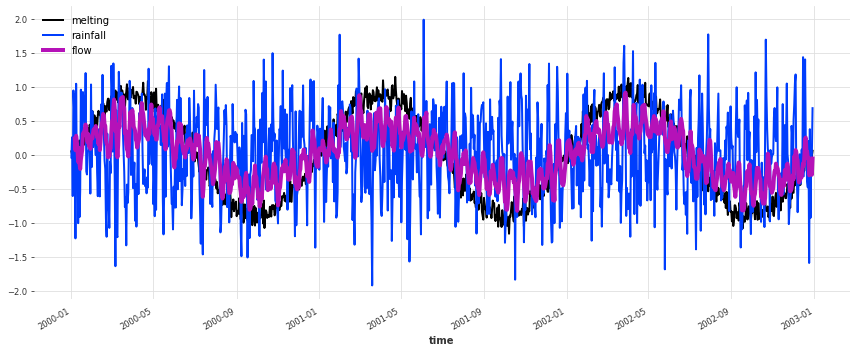

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from darts.utils import timeseries_generation as tg

np.random.seed(42)

LENGTH = 3 * 365  # 3 years of daily data

# Melting: a sine with yearly periodicity and additive white noise
melting = (0.9 * tg.sine_timeseries(length=LENGTH, value_frequency=(1/365), 
                              freq='D', 
                              column_name='melting')
           + 0.1 * tg.gaussian_timeseries(length=LENGTH, freq='D'))

# Rainfalls: a sine with bi-weekly periodicity and additive white noise
rainfalls = (0.5 * tg.sine_timeseries(length=LENGTH, 
                                value_frequency=(1/14), 
                                freq='D', 
                                column_name='rainfall')
             + 0.5 * tg.gaussian_timeseries(length=LENGTH, freq='D'))

# We shift the melting by 5 days
melting_contribution = 0.5 * melting.shift(5)

# We compute similar contribution from the rainfalls
all_contributions = [melting_contribution] + [0.1 * rainfalls.shift(lag) for lag in range(5)]

# We compute the final flow as the sum of everything; trimming series so they
# all have the same start time
flow = sum([series[melting_contribution.start_time():][:melting.end_time()]
            for series in all_contributions]).with_columns_renamed('melting', 'flow')

plt.figure(figsize=(12,5))
melting.plot()
rainfalls.plot()
flow.plot(lw=4)

### A Function to Evaluate Models

In [3]:
from darts.metrics import rmse

# We first set aside the first 80% as training series:
flow_train, _ = flow.split_before(0.8)

def eval_model(model, past_covariates=None, future_covariates=None):
    # Past and future covariates are optional because they won't always be used in our tests
    
    # We backtest the model on the last 20% of the flow series, with a horizon of 10 steps:
    backtest = model.historical_forecasts(series=flow, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=0.8, 
                                          retrain=False,
                                          verbose=True, 
                                          forecast_horizon=10)
    
    flow[-len(backtest)-100:].plot()
    backtest.plot(label='backtest (n=10)')
    print('Backtest RMSE = {}'.format(rmse(flow, backtest)))

### Using no covariates
Let's build a first model that does not use covariates.

[2021-08-09 17:42:31,712] INFO | darts.models.torch_forecasting_model | Train dataset contains 832 samples.
[2021-08-09 17:42:31,712] INFO | darts.models.torch_forecasting_model | Train dataset contains 832 samples.
[2021-08-09 17:42:31,717] INFO | darts.models.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.
[2021-08-09 17:42:31,717] INFO | darts.models.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Backtest RMSE = 0.16431122101272508


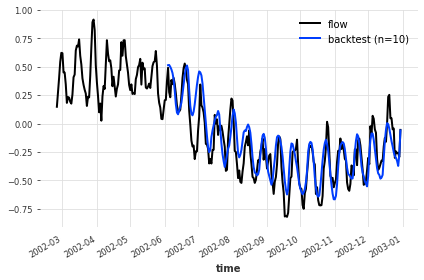

In [4]:
from darts.models import BlockRNNModel

brnn_no_cov = BlockRNNModel(input_chunk_length=30, 
                            output_chunk_length=10, 
                            n_rnn_layers=2)

brnn_no_cov.fit(flow_train, 
                epochs=100, 
                verbose=True)

eval_model(brnn_no_cov)

### Using Past covariates
Here we are free to use both melting and rainfalls, because both are known in the past at prediction time.

**Using only melting**

[2021-08-09 17:42:54,692] INFO | darts.models.torch_forecasting_model | Train dataset contains 832 samples.
[2021-08-09 17:42:54,692] INFO | darts.models.torch_forecasting_model | Train dataset contains 832 samples.
[2021-08-09 17:42:54,695] INFO | darts.models.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.
[2021-08-09 17:42:54,695] INFO | darts.models.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Backtest RMSE = 0.14340538193731486


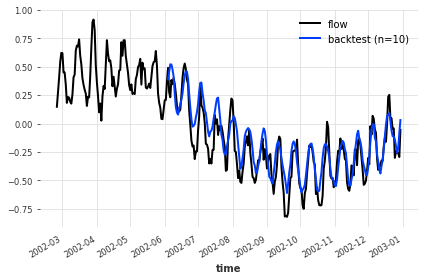

In [5]:
brnn_melting = BlockRNNModel(input_chunk_length=30, 
                             output_chunk_length=10, 
                             n_rnn_layers=2)

brnn_melting.fit(flow_train, 
                 past_covariates=melting, 
                 epochs=100, 
                 verbose=True)

eval_model(brnn_melting, 
           past_covariates=melting)

**With both melting and (past) rainfalls**

Here we can also use rainfalls. It helps but not drastically, because the model is only able to look at *past* rainfalls (before prediction time), but not at rainfalls during the 10 days' forecast horizon.

[2021-08-09 17:43:28,843] INFO | darts.models.torch_forecasting_model | Train dataset contains 832 samples.
[2021-08-09 17:43:28,843] INFO | darts.models.torch_forecasting_model | Train dataset contains 832 samples.
[2021-08-09 17:43:28,847] INFO | darts.models.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.
[2021-08-09 17:43:28,847] INFO | darts.models.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Backtest RMSE = 0.12979299191496926


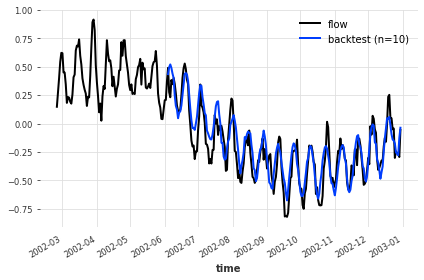

In [6]:
brnn_melting_and_rain = BlockRNNModel(input_chunk_length=30, 
                                      output_chunk_length=10, 
                                      n_rnn_layers=2)

brnn_melting_and_rain.fit(flow_train, 
                          past_covariates=melting.stack(rainfalls), 
                          epochs=100, 
                          verbose=True)

eval_model(brnn_melting_and_rain, 
           past_covariates=melting.stack(rainfalls))

### RNNModel with future covariates (rainfall):
This one will be able to factor in the knowledge of future rainfalls:

[2021-08-09 17:44:35,023] INFO | darts.models.torch_forecasting_model | Train dataset contains 831 samples.
[2021-08-09 17:44:35,023] INFO | darts.models.torch_forecasting_model | Train dataset contains 831 samples.
[2021-08-09 17:44:35,027] INFO | darts.models.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.
[2021-08-09 17:44:35,027] INFO | darts.models.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Backtest RMSE = 0.09974250854547427


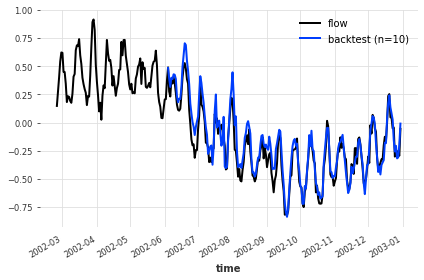

In [8]:
from darts.models import RNNModel

rnn_rain = RNNModel(input_chunk_length=30, 
                    training_length=40, 
                    n_rnn_layers=2)

rnn_rain.fit(flow_train, 
             future_covariates=rainfalls, 
             epochs=100, 
             verbose=True)

eval_model(rnn_rain, 
           future_covariates=rainfalls)

### Now, assume we also know the melting in advance
This is cheating, because at forecast time we don't know the melting. But it's a good sanity check to see that in this case the model can pick it up almost perfectly.

[2021-08-09 17:45:31,310] INFO | darts.models.torch_forecasting_model | Train dataset contains 831 samples.
[2021-08-09 17:45:31,310] INFO | darts.models.torch_forecasting_model | Train dataset contains 831 samples.
[2021-08-09 17:45:31,314] INFO | darts.models.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.
[2021-08-09 17:45:31,314] INFO | darts.models.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

Backtest RMSE = 0.007913209441169359


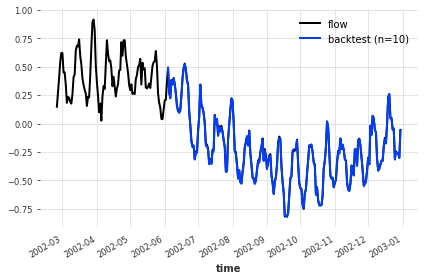

In [9]:
rnn_melting_and_rain = RNNModel(input_chunk_length=30, 
                                training_length=40, 
                                n_rnn_layers=2)

rnn_melting_and_rain.fit(flow_train, 
                         future_covariates=melting.stack(rainfalls), 
                         epochs=100, 
                         verbose=True)

eval_model(rnn_melting_and_rain, 
           future_covariates=melting.stack(rainfalls))